# Birdsongs - 05.- Preprocesando Datos - Explorando Audios

Una vez disponemos de los audios con las grabaciones de los cantos, podemos realizar el análisis de estos para comprender como funciona el audio, las diferentes transformaciones que podemos realizar sobre él, y cuales de ellas utilizaremos para presentárselas al algoritmo.

### Análisis del audio

Básicamente los que significa el sonido, un fichero de audio y las transformaciones a realizar vienen sencillamente resumidas en este artículo

https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/


>If you give a thought on what an audio looks like, it is nothing but a wave like format of data, where the amplitude of audio change with respect to time. This can be pictorial represented as follows.

![onda](./resources/da.png)

>**Data Handling in Audio domain**
>
>As with all unstructured data formats, audio data has a couple of preprocessing steps which have to be followed before it is presented for analysis.. We will cover this in detail in later article, here we will get an intuition on why this is done.
>
>The first step is to actually load the data into a machine understandable format. For this, we simply take values after every specific time steps. For example; in a 2 second audio file, we extract values at half a second. This is called sampling of audio data, and the rate at which it is sampled is called the sampling rate. 

![timefreq](./resources/time_freq.png)


> Here, we separate one audio signal into 3 different pure signals, which can now be represented as three unique values in frequency domain.
>
>There are a few more ways in which audio data can be represented, for example. using MFCs (Mel-Frequency cepstrums. PS: We will cover this in the later article). These are nothing but different ways to represent the data.
>
> Now the next step is to extract features from this audio representations, so that our algorithm can work on these features and perform the task it is designed for. Here’s a visual representation of the categories of audio features that can be extracted.

![timefreq](./resources/audio-features.png)


### Resultado

Como resultado de este notebook, podrán sacarse conclusiones acerca de como procesar los datos:
* Tipo de transformación a utilizar: oscilograma, espectrograma, MFCC?
* Tipo de canto: todos, sonido, llamada,..?
* Trocear grabación, grabación completa?
    
Así mismo, actualiza el dataset normalizando la tipología de cantos, dada las variopintas formas de determinar el tipo dentro del dataset de estudio.    
   
   
### Links de referencia

Algunos links de referencias a estudios o ideas similares

* http://cursodeacusticamusical.blogspot.com/2016/02/capitulo-10-analisis-espectral-de-los.html
* https://www.kdnuggets.com/2017/12/audio-classifier-deep-neural-networks.html
* https://spark-in.me/post/bird-voice-recognition-one
* https://www.kaggle.com/rtatman/british-birdsong-dataset/home
* https://github.com/mtobeiyf/audio-classification/blob/master/cnn.py



## 1.- Librerías

Cargamos las librerías utilizadas en el notebook

### Interactividad

* Para mostrar los desplegables de forma interactiva vamos a utilizar 
[**ipywidgets**](https://ipywidgets.readthedocs.io/en/latest/#) 

>The interact function ( ipywidgets.interact ) automatically creates user interface (UI) controls for exploring code and data interactively. It is the easiest way to get started using IPython's widgets.

      conda install -c anaconda ipywidgets


* Para la visualización de datos vamos a utilizar [**seaborn**](https://seaborn.pydata.org/), que es una librería de visualización basada en matplotlib. Para su instalación a través de conda.

      conda install -c anaconda seaborn 


### Análisis de audios

* Para el tratamiento de los audios vamos a utilizar [**libROsa**](http://librosa.github.io/librosa/). Es una librería que nos permite convertir los audios en datos, y a su vez, transformarlos en información útil en el campo de análisis de señales: oscilogramas, espectrogramas, MFCC,... Además, la ventaja que tiene frente a otras librerías, es que permite leer los audios directamente en mp3, cosa que otras librerías del tipo [PySoundfile](https://pypi.org/project/SoundFile/) o  [Soundfile](https://pysoundfile.readthedocs.io/en/0.9.0/) no soportan.

> LibROSA is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

      conda install -c conda-forge librosa 
     
* Y también utilizaremos [**scipy**](https://docs.scipy.org/doc/scipy/reference/), para el cálculo de periodogramas.

>SciPy (pronounced “Sigh Pie”) is a Python-based ecosystem of open-source software for mathematics, science, and engineering. In particular, these are some of the core packages:
     
      conda install -c anaconda scipy
      
### Análisis de cantos

Para explorar los tipos de cantos predominantes en el dataset vamos a utilizar [**wordcloud,**](https://github.com/amueller/word_cloud). Es una librería que nos permite generar una nube de palabras en función de su frecuencia dentro de un conjunto de datos.

> Compared to other wordclouds, my algorithm has the advantage of
> - filling all available space.
> - being able to use arbitraty masks.
> - having a stupid simple algorithm (with an efficient implementation) that can be easily modified.
> - being in Python

      conda install -c conda-forge wordcloud 




In [2]:
# importar librerías
import random
import numpy as np
import pandas as pd
import datetime
import os

import IPython.display as ipd
from IPython.display import Markdown, display

import scipy.signal as signal

import librosa
import librosa.display

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

## 2.- Funciones

Carga las funciones a utilizar en el notebook

### Imprime markdown

Permite imprimir utilizando el formato markdown

In [3]:
#----------------------------------------------------------------------------
# printmd(texto)
#  argumentos: 
#      string: texto a imprimir que contiene ya formato markdown
#----------------------------------------------------------------------------
def printmd(string):
    display(Markdown(string))
    

### Visualiza audio

A partir de esta función podemos leer un fichero de audio, transformarlo en datos y visualizar este como si fuera un oscilograma, espectrograma u otros formatos:

* [**Oscilograma**](https://www.acusticaintegral.com/3303/presion-sonora-oscilogramas/)

> El oscilograma de un ruido o de un sonido representa la variación de la presión sonora en función del tiempo. 

* [**Espectrograma**](https://es.wikipedia.org/wiki/Espectrograma). Utilizaremos el spectrograma de [**MEL**](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

> El espectrograma es el resultado de calcular el espectro de tramas enventanadas de una señal. Resulta una gráfica tridimensional que representa la energía del contenido frecuencial de la señal según va variando ésta a lo largo del tiempo.

   

* [**Periodograma**](https://en.wikipedia.org/wiki/Periodogram). Utilizaremos el [**Welch**](https://en.wikipedia.org/wiki/Welch%27s_method)

> In signal processing, a periodogram is an estimate of the spectral density of a signal.  The term was coined by Arthur Schuster in 1898.[1] Today, the periodogram is a component of more sophisticated methods (see spectral estimation). It is the most common tool for examining the amplitude vs frequency characteristics of FIR filters and window functions. FFT spectrum analyzers are also implemented as a time-sequence of periodograms.

  



In [4]:
#----------------------------------------------------------------------------
# show_audio(filepath, audio_selected, audio=True, oscilogram=True, 
#            spectrogram=True, mfcc=False, periodogram=True): 
#  argumentos: 
#      filepath: path del fichero de audio a tratar
#      audio_selected: ID de la grabación
#      audio: muestra widget para escuchar el canto
#      oscilogram: genera un oscilograma
#      spectrogram: genera un spectrograma
#      mfcc: genera una visualización MFCC
#      periodogram: genera un periodogram de Welch
#----------------------------------------------------------------------------
def show_audio(filepath, audio_selected, audio=True, oscilogram=True, 
               spectrogram=True, mfcc=False, periodogram=True):    
    # información de la grabación
    df_audiosel = df_birdsongs.loc[df_birdsongs['ID'] == audio_selected[:audio_selected.find('.')]]
    display(df_audiosel[['ID', 'Type','Seconds', 'Country', 'Location']])
    
    # sonido
    if audio:
        display(ipd.Audio(filepath))  
    
    # transforma audio en una matriz numpy
    data, sr = librosa.load(filepath)

    # Diferentes visualizaciones del canto
    
    # oscilograma
    if oscilogram:
        plt.figure(figsize=(14, 3))
        librosa.display.waveplot(data, sr=sr)    
        plt.title("Oscilogram")
        plt.show()
        plt.clf()
        plt.close()

    # espectrograma
    if spectrogram:
        melgram = librosa.feature.melspectrogram(data, sr=sr, n_mels=128)
        log_melgram = librosa.amplitude_to_db(melgram, ref=np.max)
    
        seconds = int(df_audiosel['Seconds'])
    
        if seconds > 15:
            size = 14
        elif seconds < 2:
            size = 2
        else:
            size = seconds

        plt.figure(figsize=(size, 3))
        librosa.display.specshow(log_melgram, sr=sr, x_axis='time', y_axis='hz')
        plt.title("MEL log scale Spectrogram")
        plt.tight_layout()
        plt.show()    
        plt.clf()
        plt.close()
        
    # mfcc
    if mfcc:
        mfcc = librosa.feature.mfcc(S=log_melgram, n_mfcc=20)
        plt.figure(figsize=(10, 3))
        librosa.display.specshow(mfcc, x_axis='time')
        plt.title("MFCC")
        plt.tight_layout()
        plt.colorbar()
        plt.show()    

        plt.clf()
        plt.close()
        
    
    # periodograma Welch
    if periodogram:
        f, Pxx_spec = signal.welch(data, sr, 'flattop', 11024, scaling='spectrum')
    
        plt.figure(figsize=(4, 3))
        plt.semilogy(f, np.sqrt(Pxx_spec))
        plt.xlabel('frequency [Hz]')
        plt.ylabel('Linear spectrum [V RMS]')
        plt.title("Welch Periodogram")
        plt.tight_layout()
        plt.show()    
        plt.clf()
        plt.close()  
    

### Normaliza tipos de cantos

Permite normalizar los tipos de cantos presentes en el dataset en unas categorías básicas.

* call.- llamada
* song.- canto
* icall.- incluye llamada
* isong.- incluye canto
* other.- otros tipos 

In [25]:
#----------------------------------------------------------------------------
# normalize_type(songtype)
#  argumentos: 
#      songtype: tipo de canto
#  retorna: 
#      tipo de canto normalizado
#----------------------------------------------------------------------------
def normalize_type(songtype):
    OTHERS = 'others'
    
    if songtype.strip().lower() == 'call':
        return songtype

    if songtype.strip().lower() == 'song':
        return songtype
    
    if songtype.strip().lower().find('song') != -1:
        if songtype.strip().lower().find('call') != -1:
            return OTHERS
        else:
            return 'isong'

    if songtype.strip().lower().find('call') != -1:
        if songtype.strip().lower().find('song') != -1:
            return OTHERS
        else:
            return 'icall'

    return OTHERS

## 3.- Repositorio audios 

Determina el path donde se almacen los ficheros con los audios en mp3

In [5]:
# repositorio con los ficheros de audio
audiopath = './audio'

## 4.- Carga dataset

Carga el dataset de trabajo y genera un nuevo dataframe agrupando por especies

In [6]:
# carga el dataset
df_path = 'Birdsongs_My_Birdsongs_Europe_20181230103204.csv'
df_birdsongs = pd.read_csv(df_path)

# agrupa por nombre científico
df_species = df_birdsongs.groupby('Name')['ID'].count()

# crea un nuevo dataframe con las especies y el número de registros por cada una de ellas
df_species = df_species.reset_index()
df_species.columns = ['Name', 'Count'] 


## 5.- Explora audios filtrando por especie

Muestra un desplegable con todas las especies de las que tenemos grabación y nos permite seleccionar una, mostrando un dataframe con todos los cantos asociados a la especie

In [7]:
# especie seleccionada
specie_selected = ''

# dataframe con las grabaciones pertenecientes a la especie seleccionada
df_speciesel = pd.DataFrame([])

@interact(Specie=df_species['Name'])
def select_specie(Specie):
    global specie_selected
    global df_speciesel
    
    # especie seleccionada en el desplegable
    specie_selected = Specie

    # genera dataframe y muestra ID, tipo de canto, duración, país y localización
    df_speciesel = df_birdsongs.loc[df_birdsongs['Name'] == specie_selected]
    display(df_speciesel[['ID', 'Type','Seconds', 'Country', 'Location']])
    


interactive(children=(Dropdown(description='Specie', options=('Acanthis flammea', 'Acrocephalus arundinaceus',…

In [8]:
# recupera los ficheros de audio existentes para esta especie
specie_dir = os.path.join(audiopath, specie_selected)
specie_audios = os.listdir(specie_dir)
specie_audios.sort()
number_audios = len(specie_audios)

printmd("#### **" "Especie seleccionada: " +  specie_selected + "**")
print("Número de audios:", number_audios)

#### **Especie seleccionada: Troglodytes troglodytes**

Número de audios: 250


### 5.1.- Explora tipos de canto según especie

Para la especie seleccionada, permite visualizar en un desplegable los tipos de cantos de los que tenemos grabaciones.

https://es.wikipedia.org/wiki/Vocalizaci%C3%B3n_de_las_aves

>El término vocalización de las aves se refiere a los sonidos vocales que estos animales emiten, incluyendo tanto el canto (gorjeo, trino) como los reclamos. A un nivel no técnico, el canto son los sonidos que emiten las aves y que son melodiosos al oído humano. En ornitología, el canto de las aves se diferencia de los sonidos cortos distintivos, a menudo denominados reclamos o llamadas.1​

>Definición
La diferencia entre canto y reclamo es de alguna manera arbitraria. Los cantos son más largos y complejos y están asociados al cortejo y apareamiento, mientras los reclamos tienden a prestar función de alarma o para mantener junta a la bandada y en comunicación.2​ Otras autoridades como Howell y Webb (1995) hacen la distinción sobre la base de su función, de esta forma, vocalizaciones cortas como las de las palomas e incluso, sonidos no vocales como el "tamborileo" de los pájaros carpinteros o el batido de las alas de la agachadiza en sus vuelos de exhibición son considerados cantos.3​ Sin embargo, otros autores enfatizan que el canto debe poseer diversidad silábica y regularidad temporal semejante a los patrones repetitivos y transformativos que definen la música.



In [21]:
# Tipo seleccionado
type_selected = ''

# Crea dataframe con los tipos de cantos presentes en las grabaciones, y elimina duplicados
df_audiotype = df_speciesel['Type']
df_audiotype = df_audiotype.drop_duplicates(keep='first')

@interact(Type=df_audiotype)
def select_specie(Type):
    global type_selected
    type_selected =Type
    

interactive(children=(Dropdown(description='Type', options=('song', 'call', 'alarm call', 'call, female, juven…

Visualizando los tipos de cantos, vemos que existe bastante heterogeneidad en los tipos de cantos presentes en las grabaciones, aunque podrían resumirse en cantos y llamadas

### 5.2.- Visualiza muestras según tipo de canto

Visualizamos una muestra de los audios que forman parte del dataset, para la especie y el tipo de canto seleccionado, observando el oscilograma, espectrograma y periodograma

Jugar con estas visualizaciones nos permiten ver a simple vista si existen o no patrones repetitivos identificables entre los distintos tipos de grabaciones y/o tipos de cantos.


muestra: 5


#### **1) XC134273 - Troglodytes troglodytes**

ID  Type  Seconds      Country  \
10294  XC134273  song       56  Netherlands   

                                          Location  
10294  Schiermonnikoog, Schiermonnikoog, Friesland

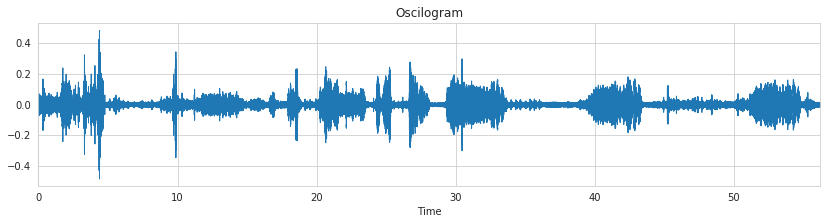

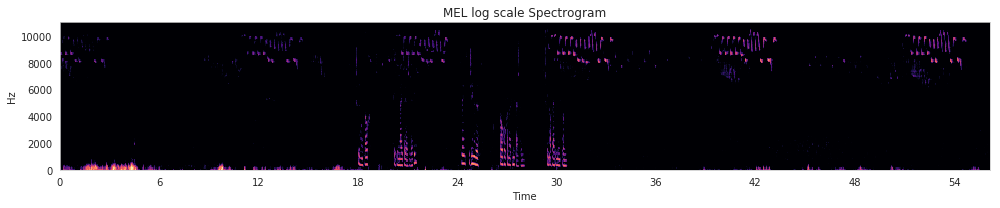

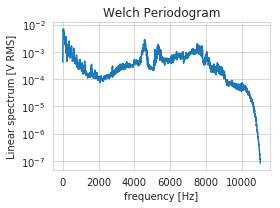

#### **2) XC36904 - Troglodytes troglodytes**

ID  Type  Seconds      Country                 Location
10167  XC36904  song       24  Netherlands  Drievliet, Rijswijk, ZH

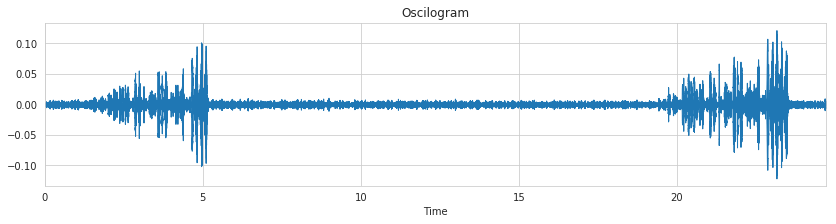

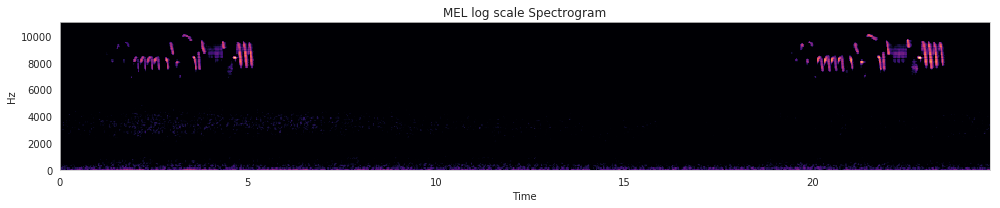

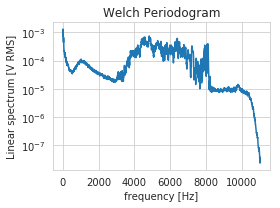

#### **3) XC320884 - Troglodytes troglodytes**

ID  Type  Seconds  Country  \
10110  XC320884  song       26  Germany   

                                                Location  
10110  Essen-Fischlaken, Ruhrgebiet, Nordrhein-Westfalen

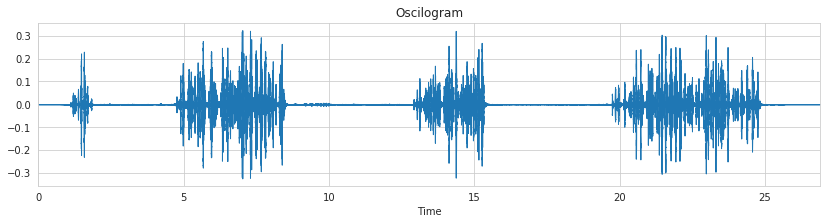

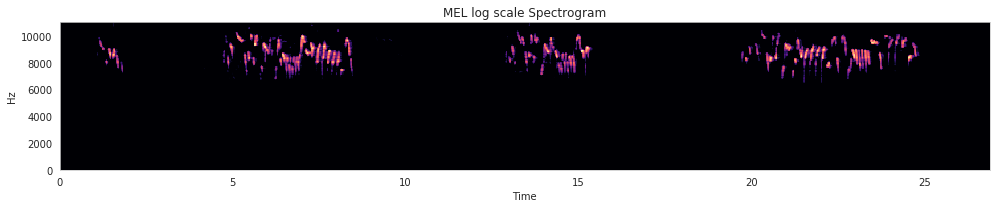

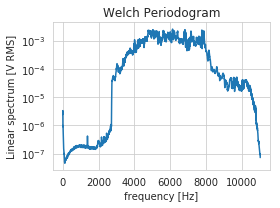

#### **4) XC434847 - Troglodytes troglodytes**

ID  Type  Seconds   Country  \
10075  XC434847  song       11  Portugal   

                                    Location  
10075  Santiago (near  Tavira), Tavira, Faro

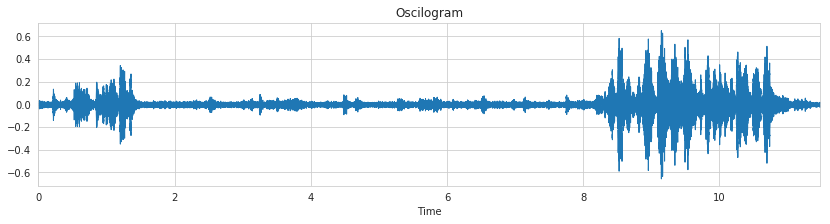

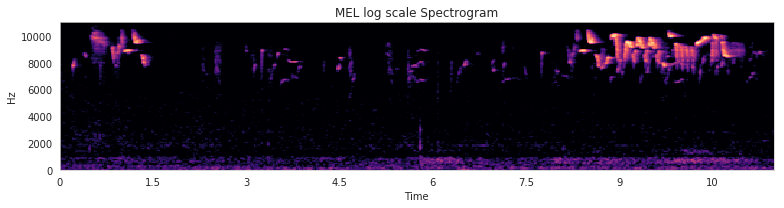

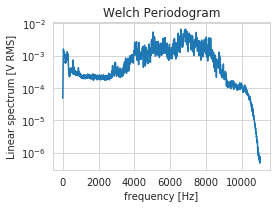

#### **5) XC208412 - Troglodytes troglodytes**

ID  Type  Seconds  Country                           Location
10275  XC208412  song       26  Finland  Jerikonmäki, Kirkkonummi, Uusimaa

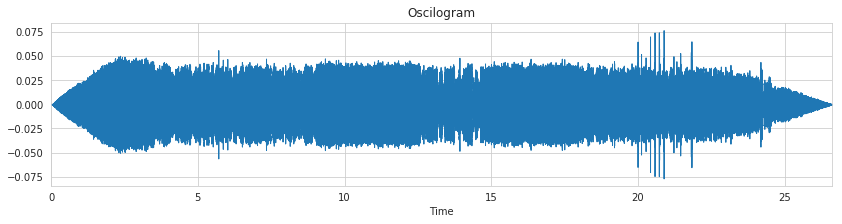

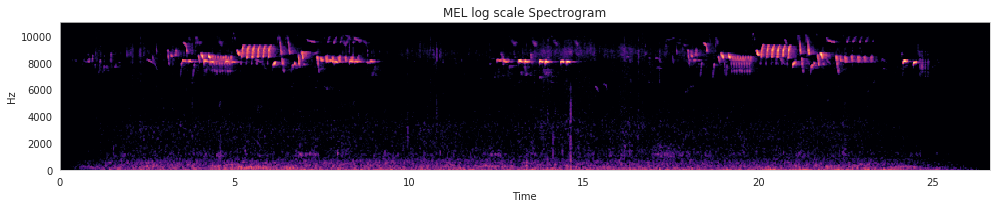

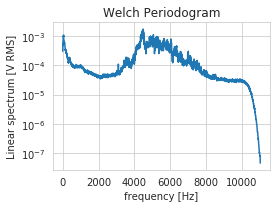

In [14]:
# lista con las grabaciones filtrando por tipo de canto
l_audios = list(df_speciesel.loc[df_birdsongs['Type'] == type_selected, 'ID'])

# tamaño de la muestra
sample = 5

if sample > len(l_audios):
    sample = len(l_audios)

print("muestra:", sample)
 
# selecciona al azar el número de muestras a estudiar y muestra la información relativa a ellas.
for e, s in enumerate(random.sample(l_audios, sample)):
    printmd("#### **" + str(e + 1) + ') ' +  s + ' - ' + specie_selected + "**")
    
    file = s + '.mp3'
    filepath =os.path.join(specie_dir, file)
    show_audio(filepath, file)
    

### 5.3.- Visualiza periodogramas

Exploramos visualmente varios periodogramas de todo tipo de cantos de la especie seleccionada, para ver si vemos algún patrón común que se repita y que nos pueda dar idea si utilizando los periodogramas el modelo podría dar mejores resultados

muestra: 5


#### **1) XC298007 - Troglodytes troglodytes**

ID  Type  Seconds      Country                     Location
10120  XC298007  call       20  Switzerland  Cudrefin, Broye-Vully, Vaud

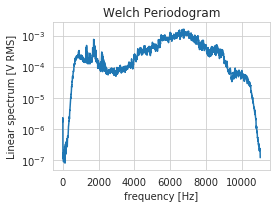

#### **2) XC397288 - Troglodytes troglodytes**

ID                Type  Seconds  Country  \
10189  XC397288  plastic song, song       21  Ireland   

                                    Location  
10189  Threecastles, Wicklow, County Wicklow

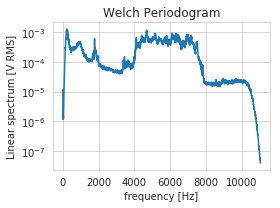

#### **3) XC424966 - Troglodytes troglodytes**

ID  Type  Seconds Country                           Location
10081  XC424966  song       30  Sweden  Skinnskatteberg, Västmanlands län

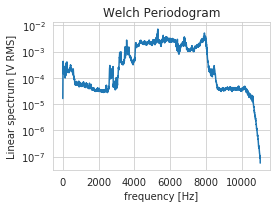

#### **4) XC333350 - Troglodytes troglodytes**

ID                      Type  Seconds Country  \
10226  XC333350  alarm call, begging call       37  France   

                                                Location  
10226  Termes, Lozère, Languedoc-Roussillon Midi-Pyré...

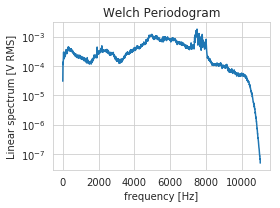

#### **5) XC253289 - Troglodytes troglodytes**

ID  Type  Seconds Country                              Location
10271  XC253289  song       32  France  Rochefort-Samson, Drôme, Rhône-Alpes

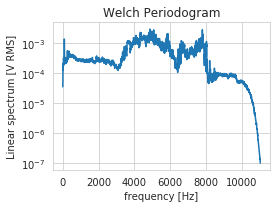

In [15]:
# lista con audios de la especie seleccionada
l_audios = list(df_speciesel['ID'])

# tamaño de la muestra
sample = 5

if sample > len(l_audios):
    sample = len(l_audios)

print("muestra:", sample)

# muestra periodogramas
for e, s in enumerate(random.sample(l_audios, sample)):
    printmd("#### **" + str(e + 1) + ') ' +  s + ' - ' + specie_selected + "**")
    
    file = s + '.mp3'
    filepath =os.path.join(specie_dir, file)
    show_audio(filepath, file, audio=False, oscilogram=False, spectrogram=False)
    

### 5.4.- Explora audio

Permite seleccionar una de las grabaciones de la especie seleccionada y visualizarla

In [16]:
audio_selected = '' 
filepath = ''
df_audiosel = pd.DataFrame([])

@interact(Audio=specie_audios)
def select_specie(Audio):
    global audio_selected
    global filepath
    global df_audiosel
    
    audio_selected =Audio
    
    filepath =os.path.join(specie_dir, audio_selected)
    show_audio(filepath, audio_selected)    
    

interactive(children=(Dropdown(description='Audio', options=('XC110321.mp3', 'XC115539.mp3', 'XC121361.mp3', '…

### 5.5.- Explora audio en tramas

Corta la grabación en tramas de un tamaño especifico y visualiza cada una de ellas. 

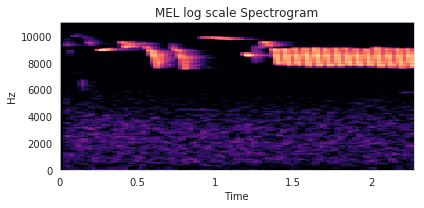

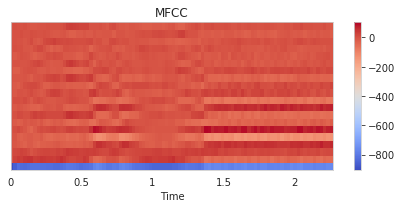

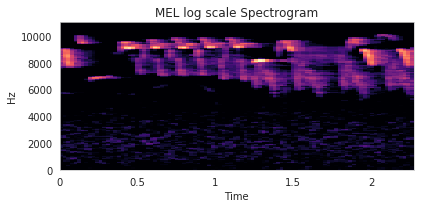

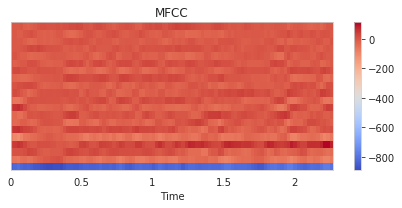

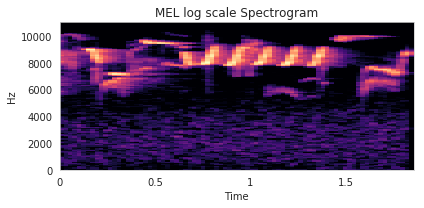

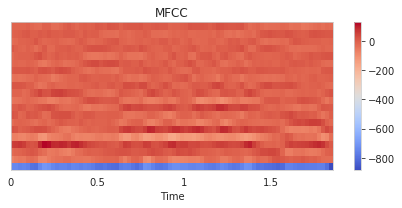

In [20]:
# lee audio
data, sr = librosa.load(filepath)

pointer = 0

# tamaño de la trama
chunk = 50000

while pointer < len(data):
    # espectrograma
    melgram = librosa.feature.melspectrogram(data[pointer:pointer + chunk], sr=sr, n_mels=128)
    log_melgram = librosa.amplitude_to_db(melgram, ref=np.max)
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(log_melgram, sr=sr, x_axis='time', y_axis='hz')
    plt.title("MEL log scale Spectrogram")
    plt.tight_layout()
    plt.show()    
    plt.clf()
    plt.close()
        
    # mfcc coeficientes
    mfcc = librosa.feature.mfcc(S=log_melgram, n_mfcc=20)
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title("MFCC")
    plt.tight_layout()
    plt.colorbar()
    plt.show()    

    plt.clf()
    plt.close()
    
    pointer += chunk
    

## 6.- Visualizando tipología de cantos 

Ya hemos visto que los patrones de canto varían en algunos casos bastante en relación al tipo. No es lo mismo un canto, una llamada, canto en vuelo, etc.. Mediante wordcloud miramos que tipos de cantos son los más comunes, para realizar una selección de grabaciones para un tipo concreto de canto.

https://www.datacamp.com/community/tutorials/wordcloud-python

In [23]:
# serie con los tipos de cantos
s = df_birdsongs['Type']

# lista con todos ellos
sr = s.str.cat(sep=',')


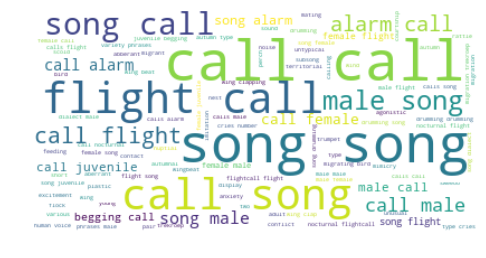

In [24]:
# Crea wordcloud 
wordcloud = WordCloud().generate(sr)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sr)

# Plotea imagenes
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

###  6.1.- Normaliza tipos de cantos

Existen como 900 tipos distintos de cantos, o al menos así los han catalogado a la hora de subir la grabación a la web. Vamos a normalizar los tipos, y vamos a crear una nueva tipología que incluirán los siguientes:

* song
* call
* contiene "song"
* contiene "call"
* otros (sin una grabación está categorizada como song y call la incluimos en este grupo)


In [27]:
# agrupa por los tipos de cantos
df_birdsongs['Type'] = df_birdsongs['Type'].str.lower()
df_types = df_birdsongs.groupby('Type')['ID'].count()

# crea un nuevo dataframe con los tipos y el número de registros por cada una de ellos
df_types = df_types.reset_index()
df_types.columns = ['Type', 'Count'] 


In [28]:
# filtra los 20 tipos con más valores
df_types.sort_values(by='Count', ascending=False).head(20)['Count'].sum()
df_types.sort_values(by='Count', ascending=False).head(20)

Type  Count
835                               song   5563
325                               call   4676
657                        flight call   1193
751                         male, song   1080
133                         alarm call    743
505                         call, song    517
418                  call, flight call    273
470                         call, male    262
401    call, female, flight call, male    161
158                   alarm call, call    151
464                     call, juvenile    138
299             begging call, juvenile    130
396                       call, female    124
618                           drumming    117
273                       begging call     93
407                 call, female, male     84
471                   call, male, song     80
216                   alarm call, male     70
684                  flight call, song     58
679  flight call, nocturnal flightcall     41

Crea nueva columna en el dataset normalizando los tipos de cantos

In [29]:
# normaliza tipos
df_types['nType'] = df_types['Type'].apply(normalize_type)
df_types.head()

Type  Count  nType
0      ""oriolus"-call, call      1  icall
1   "cha-cha-cha" call, call      1  icall
2  "chaffinch call", mimicry      1  icall
3          "diup" call, call      1  icall
4   "djiek" call, alarm call      1  icall

### 6.2.- Actualiza el dataset

Actualizamos el dataset con las grabaciones con la nueva tipología que nos permitirá realizar posteriores análisis en función del tipo de canto

In [30]:
# Crea nueva tipología
df_birdsongs['nType'] = df_birdsongs['Type'].apply(normalize_type)

# Actualiza el dataset
df_birdsongs.to_csv(df_path, index=False)